# US Department of Education College Scorecard Data Analysis

#### It is well known that having a college degree of some kind increases your earning potential for the rest of your life by a significant amount. But, are higher tuition costs possibly justified because they're correlated with higher post-graduate earnings? How is the admissions rate of a college related to graduates' earning potential? Are more selective colleges more expensive? To answer these questions, we turn to the US Department of Education's College Scorecard Data.

First, let's import data and necessary packages.

In [1]:
import pandas as pd
import numpy as np
import thinkplot
import thinkstats2
from IPython.display import display
%matplotlib inline

#load 2012-13 and 2014-15 College Scorecard data
cs2012_13 = pd.read_csv('CollegeScorecard_Raw_Data/MERGED2012_13_PP.csv')
cs2014_15 = pd.read_csv('CollegeScorecard_Raw_Data/MERGED2014_15_PP.csv')

#for some odd reason, the first column of the DataFrames, UNITID, can't be accessed with 'UNITID'
#renaming the columns fixes the problem
col_name=cs2012_13.columns[0]
cs2012_13 = cs2012_13.rename(columns = {col_name:'UNITID'})
col_name=cs2014_15.columns[0]
cs2014_15 = cs2014_15.rename(columns = {col_name:'UNITID'})

#print number of rows in each DataFrame to check the number of institutions in each DataFrame
print('Number of colleges in 2012-13 dataset: %i' %(cs2012_13.shape[0] + 1))
print('Number of colleges in 2014-15 dataset: %i' %(cs2014_15.shape[0] + 1))

/home/william/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (1537,1540,1542,1575,1606,1614,1615,1729) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/william/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (6,9,1379,1380,1381,1382,1383,1384,1385,1386,1387,1388,1389,1390,1391,1392,1393,1394,1395,1396,1397,1398,1399,1400,1401,1402,1403,1404,1405,1406,1407,1411,1425,1427,1503,1517,1529,1530,1532,1537,1540,1541,1542,1575,1576,1577,1578,1579,1580,1581,1582,1583,1584,1585,1586,1587,1588,1589,1590,1591,1592,1593,1594,1595,1596,1597,1598,1599,1600,1601,1602,1605,1606,1609,1610,1613,1614,1615,1725,1726,1727,1728,1729) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Number of colleges in 2012-13 dataset: 7794
Number of colleges in 2014-15 dataset: 7704


If we're looking at answering some of these questions as a way to help people make choices between colleges, then we should first filter out institutions that are no longer operating.

Because the 2012-13 dataset contains the mean earnings after graduation data that we're interested in but no data on whether or not schools are operating, we need to match the operating data from the 2014-15 dataset to schools in the 2012-13 dataset.

In [2]:
cs2014_15_selected = cs2014_15.copy(deep=True)
cs2014_15_selected = cs2014_15_selected[['UNITID', 'OPEID', 'OPEID6', 'CURROPER']]

#first, remove CURROPER column from cs2012_13 that only has NaNs
cs2012_13.drop('CURROPER', 1, inplace=True)

#match colleges using UNITID
cs2012_13 = cs2012_13.merge(cs2014_15_selected, left_on='UNITID', right_on='UNITID', how='outer')
cs2012_13.drop('OPEID_y', 1, inplace=True)
cs2012_13.drop('OPEID6_y', 1, inplace=True)

#drop extraneous data that didn't match up as a byproduct of the merge
cs2012_13.dropna(subset=['UNITID'], inplace=True)
cs2012_13.dropna(subset=['OPEID_x'], inplace=True)
cs2012_13.dropna(subset=['OPEID6_x'], inplace=True)

#fill in NaNs in CURROPER column with 0s
cs2012_13['CURROPER'].fillna(0, inplace=True)

operating = cs2012_13.copy(deep=True)
operating = operating[operating.CURROPER == 1]

operating.rename(columns={'OPEID_x': 'OPEID', 'OPEID6_x': 'OPEID6'})

print('Number of colleges in 2012-13 dataset currently operating: %i' %(operating.shape[0] + 1))

Number of colleges in 2012-13 dataset currently operating: 6530


After filtering for operating institutions, we go from a total list of 7794 institutions to 6530. Some colleges do close, as evidenced by the 90 institution difference between the 2012-13 and 2014-15 dataset. Considering the fact that the College Scorecard contains data for every institution of higher learning in the United States, the yearly churn in institutions shows. That churn, however, definitely does not add up to 1174 institutions, and the way the data is coded in the Scorecard is partially to blame. We match institutions from the 2014-15 dataset to institutions in the 2012-13 dataset using each institution's unique UNITID number. However, from year to year, some institutions' ID numbers change and they get dropped from the dataset. Attempting to compare OPEID or OPEID6 values is a challenge due to the possibility that different institutions may have the same OPEID or OPEID6.

Because what degree you get from college will significantly impact your earning potential (e.g. a person with a PhD is going to be paid more than someone with a bachelor's degree), we're going to focus on institutions that mainly award bachelor's degrees. Let's select for those institutions.

In [3]:
#select operating institutions that mainly award bachelor's degrees
bachelors = operating[operating.PREDDEG == 3]
print('Number of currently operating colleges in 2012-13 dataset that primarily offer bachelor\'s degrees: %i' %(bachelors.shape[0] +1 ))

Number of currently operating colleges in 2012-13 dataset that primarily offer bachelor's degrees: 1976


After selecting for institutions that primarily award bachelor's degrees, we're down to 1976 colleges. This cuts out a significant number of institutions from our dataset, so we'll revisit adding in colleges that predominantly award associate's degrees later, especially because many institutions that fall into that category, like community colleges, are a common option for college. For now, however, this will be the cleaned, base dataset we will be working from.

Now, we need to consolidate some of the cost data for institutions. The differences between institutions that use an academic year based calendar system and program-based or continuous enrollment calendar systems does not mean much to us, especially when the College Scorecard annualizes cost data for program-based or continuous enrollment calendar system institutions. Because the Scorecard separates out average annual cost of attendance for academic year institutions and program year institutions, we need to combine the data into a single DataFrame column.

In [4]:
#make a copy of our dataset to make it easier to make more data comparisons later on
bachelors_cost = bachelors.copy(deep=True)

for i in range(bachelors_cost.COSTT4_A.shape[0]):
    if np.isnan(bachelors_cost.COSTT4_A.iloc[i]) == False and np.isnan(bachelors_cost.COSTT4_P.iloc[i]) == False:
        print("BOTH VALUES EXIST") #makes sure there is no institution with both COSTT4_A and COSTT4_P data

#filters out institutions without earnings data
bachelors_cost = bachelors_cost[bachelors_cost['COSTT4_A'].notnull() | bachelors_cost['COSTT4_P'].notnull()]

bachelors_cost['COSTT4_A'].fillna(0, inplace=True)
bachelors_cost['COSTT4_P'].fillna(0, inplace=True)
bachelors_cost['COST_COMBO'] = bachelors_cost['COSTT4_A'] + bachelors_cost['COSTT4_P']

print('Colleges in working dataset: %i' %(bachelors_cost.shape[0] + 1))

Colleges in working dataset: 1855


Because not all schools in the dataset have cost data, we're now down to 1855 colleges. Many institutions also don't meet NSLDS and Treasury reporting standards, so their earnings data in the Scorecard is obscured with 'PrivacySuppressed'. Ultimately, that means that we also have to drop those schools from our dataset as well.

In [5]:
bachelors_cost_earnings = bachelors_cost.copy(deep=True)

#removes schools whose earnings data does not meet NSLDS and Treasury reporting standards
bachelors_cost_earnings = bachelors_cost_earnings[bachelors_cost_earnings.MN_EARN_WNE_P10 != 'PrivacySuppressed']
#removes schools without earnings data
bachelors_cost_earnings.dropna(subset=['MN_EARN_WNE_P10'], inplace=True)

print('Colleges in working dataset: %i' %(bachelors_cost_earnings.shape[0] + 1))

Colleges in working dataset: 1712


We're now down to 1712 colleges. Let's see what the relationship between college cost and mean earnings after 10 years looks like. Specifically, we're looking at the relationship between a school's average cost of attendance and that school's students' mean earnings 10 years after graduation.

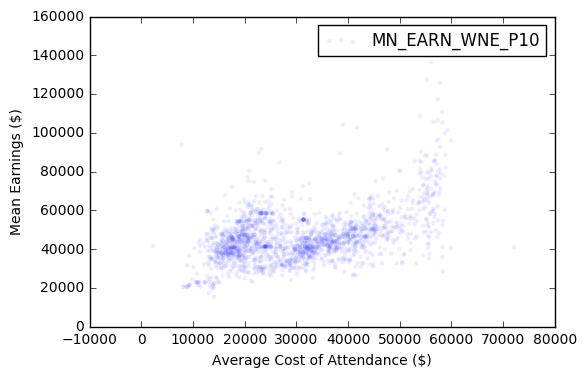

In [6]:
costs = bachelors_cost_earnings.COST_COMBO
earnings = bachelors_cost_earnings.MN_EARN_WNE_P10

thinkplot.Scatter(costs, earnings, alpha=0.07, s=10)
thinkplot.Show(xlabel='Average Cost of Attendance ($)',
               ylabel='Mean Earnings ($)')

# bachelors_cost_earnings[pd.to_numeric(bachelors_cost_earnings.MN_EARN_WNE_P10, errors='coerce') > 150000]
# bachelors_cost_earnings[pd.to_numeric(bachelors_cost_earnings.COST_COMBO, errors='coerce') > 70000].COST_COMBO

To be able to better interpret the data, let's calculate the Spearman Correlation for our data.

In [7]:
thinkstats2.SpearmanCorr(costs, earnings)

0.35505617484373792

We can see here that there is a slight correlation between the mean earnings of an institution's graduates 10 years after graduation, which is consistent with a Spearman rank correlation of 0.355. There are definitely some institutions that charge their students more, but provide a commensurate return on investment.

Beyond possibly needing to pay more for a school that will potentially make you more money in the future, let's see if more "exclusive" schools cost more. To do this, let's go back to our dataset filtered out for school's 
cost data and drop schools that don't have a reported admissions rate.

In [8]:
bachelors_adm = bachelors_cost[pd.notnull(bachelors_cost['ADM_RATE'])]
print('Colleges in working dataset: %i' %(bachelors_adm.shape[0] + 1))

Colleges in working dataset: 1601


Dropping those schools leaves us with 1601 institutions. Let's graph the data and calculate its Spearman's correlation to see if there is a correlation.

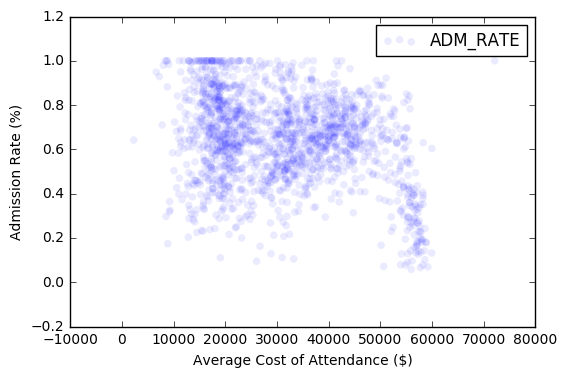

-0.2115575068123616

In [9]:
costs = bachelors_adm.COST_COMBO
adm_rate = bachelors_adm.ADM_RATE

thinkplot.Scatter(costs, adm_rate, alpha=0.08)
thinkplot.Show(xlabel='Average Cost of Attendance ($)',
               ylabel='Admission Rate (%)')

thinkstats2.SpearmanCorr(costs, adm_rate)

With a Spearman's rank correlation of -0.211, there seems to be a slight correlation between a school's admissions rate and a school's average cost of attendance. Especially if you look at the right side of the scatterplot, there seem to be a group of schools that have a low admissions rate, but charge a lot.

With that, let's see if an institution's admissions rate has any bearing on the institution's graduates' earning potential.

Colleges in working dataset: 1510


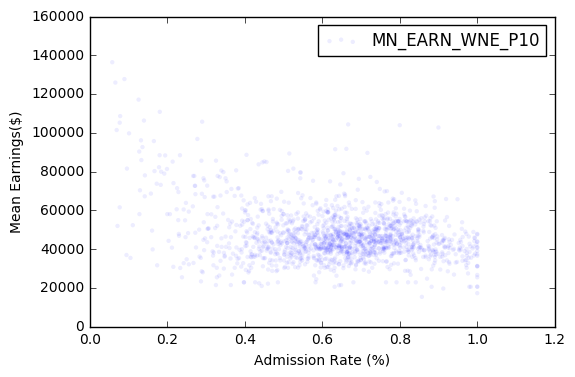

-0.10167726263262389

In [10]:
bachelors_earnings_adm = bachelors[pd.notnull(bachelors['MN_EARN_WNE_P10'])]
bachelors_earnings_adm = bachelors_earnings_adm[bachelors_earnings_adm.MN_EARN_WNE_P10 != 'PrivacySuppressed']
bachelors_earnings_adm = bachelors_earnings_adm[pd.notnull(bachelors_earnings_adm['ADM_RATE'])]

print('Colleges in working dataset: %i' %(bachelors_earnings_adm.shape[0] + 1))

adm_rate = bachelors_earnings_adm.ADM_RATE
earnings = bachelors_earnings_adm.MN_EARN_WNE_P10

thinkplot.Scatter(adm_rate, earnings, alpha=0.07, s=10)
thinkplot.Show(xlabel='Admission Rate (%)', 
               ylabel='Mean Earnings($)')

thinkstats2.SpearmanCorr(adm_rate, earnings)

With a Spearman's rank correlation of -0.101, it would appear as if there is no correlation between an institution's admissions rate and an institution's graduates' mean earnings 10 years after graduation. However, in the scatterplot, it appears as if there are a small number of institutions with very low admissions rates that have graduates that make a significant amount of money 10 years after graduating. There are a number of factors that could potentially support a link between low admissions rates and higher earnings after graduation, but the data as we have analyzed it do not support or refute such a link. If you ignore the outliers on the left of the scatterplot, the vast majority of the data suggest that an institution's exclusivity does not affect its graduates' mean earnings.